In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [5]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

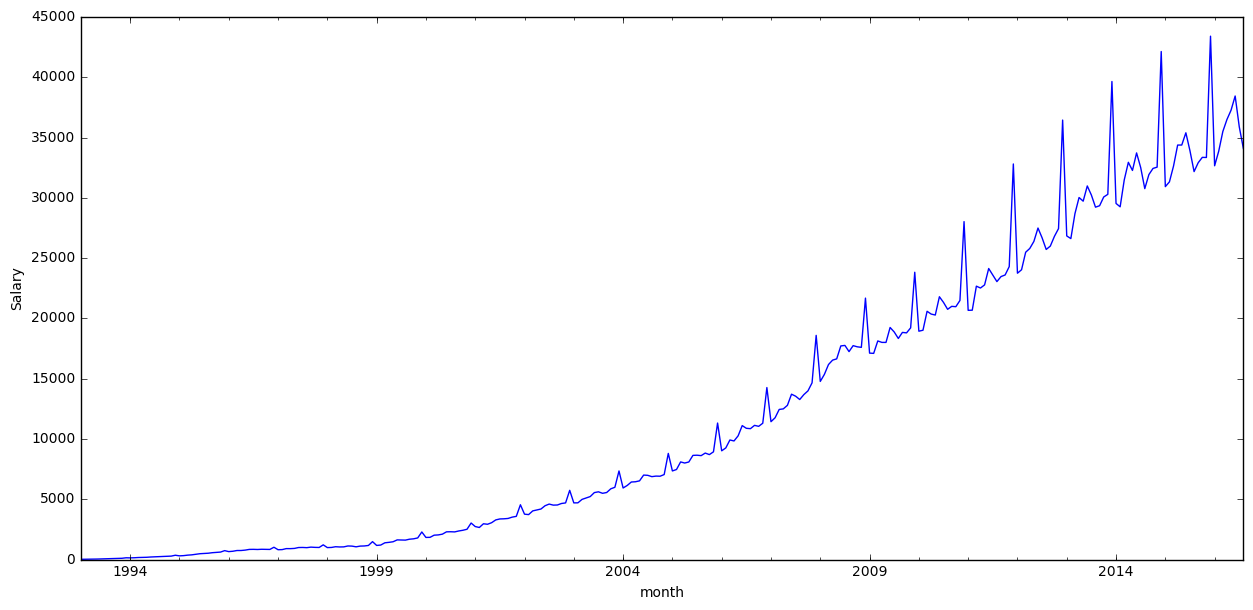

In [15]:
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

На графике четко заметен возрастающий тренд, также присутствует годовая сезонность, дисперсия также растет

Проверим стационарность и STL-декомпозицию ряда, как в примере:

Критерий Дики-Фуллера: p=0.991850


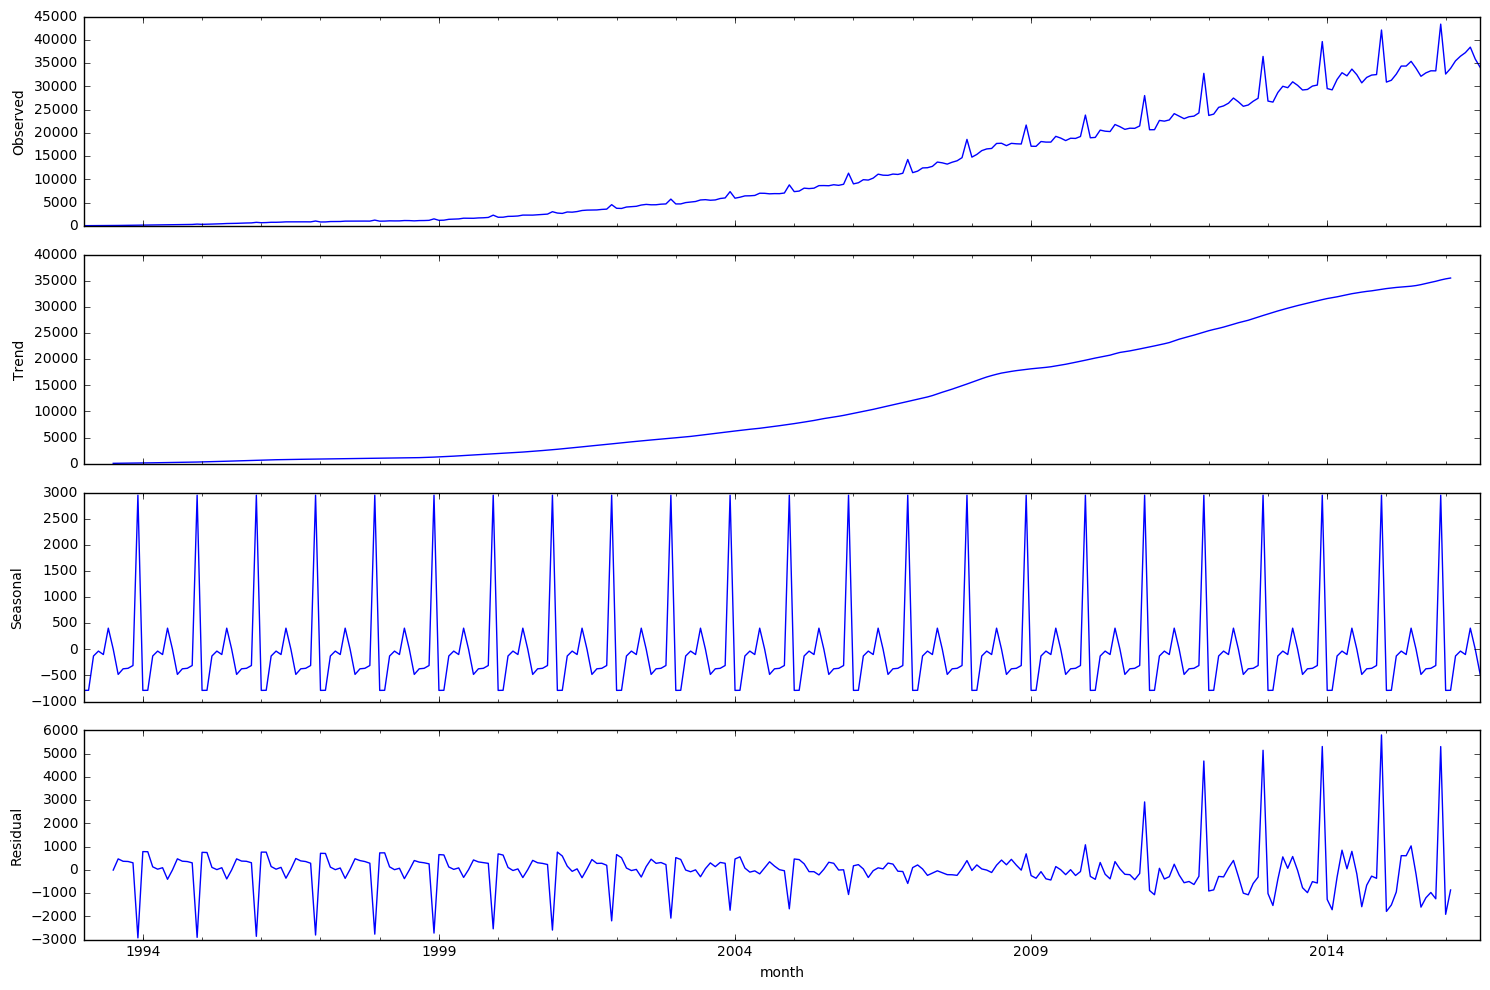

In [16]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

Ряд действительно вообще не стационарен

Для начала стабилизируем дисперсию:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


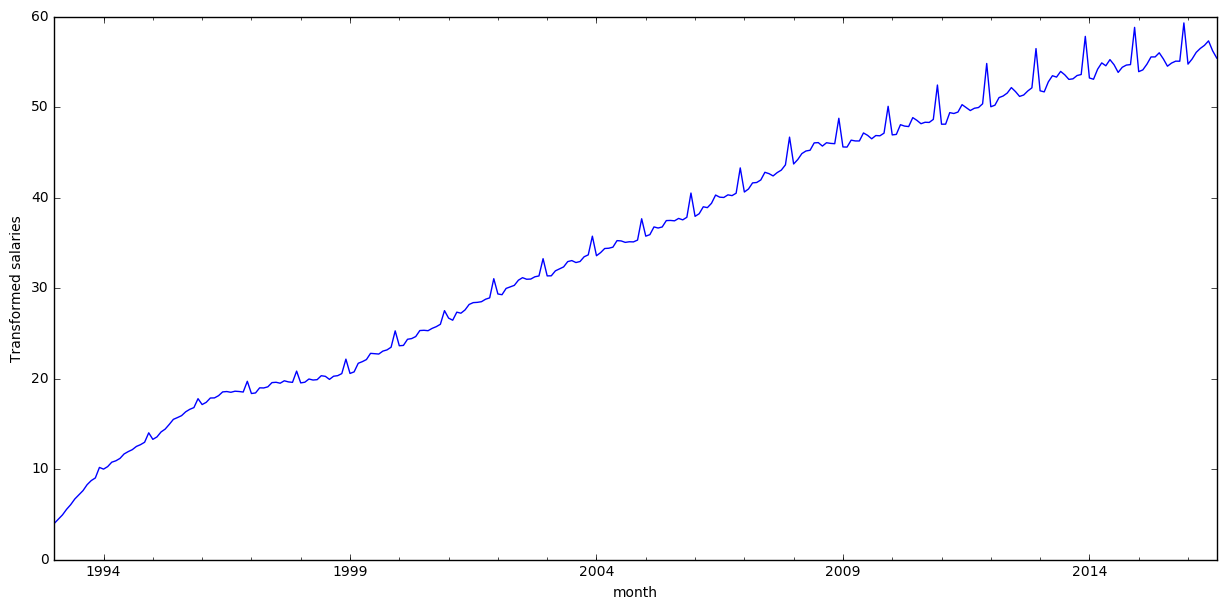

In [17]:
data['WAG_DF'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_DF.plot()
plt.ylabel(u'Transformed salaries')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_DF)[1])

Ряд по прежнему не стационарен, сделаем сезонное диффиренцирование:

Критерий Дики-Фуллера: p=0.014697


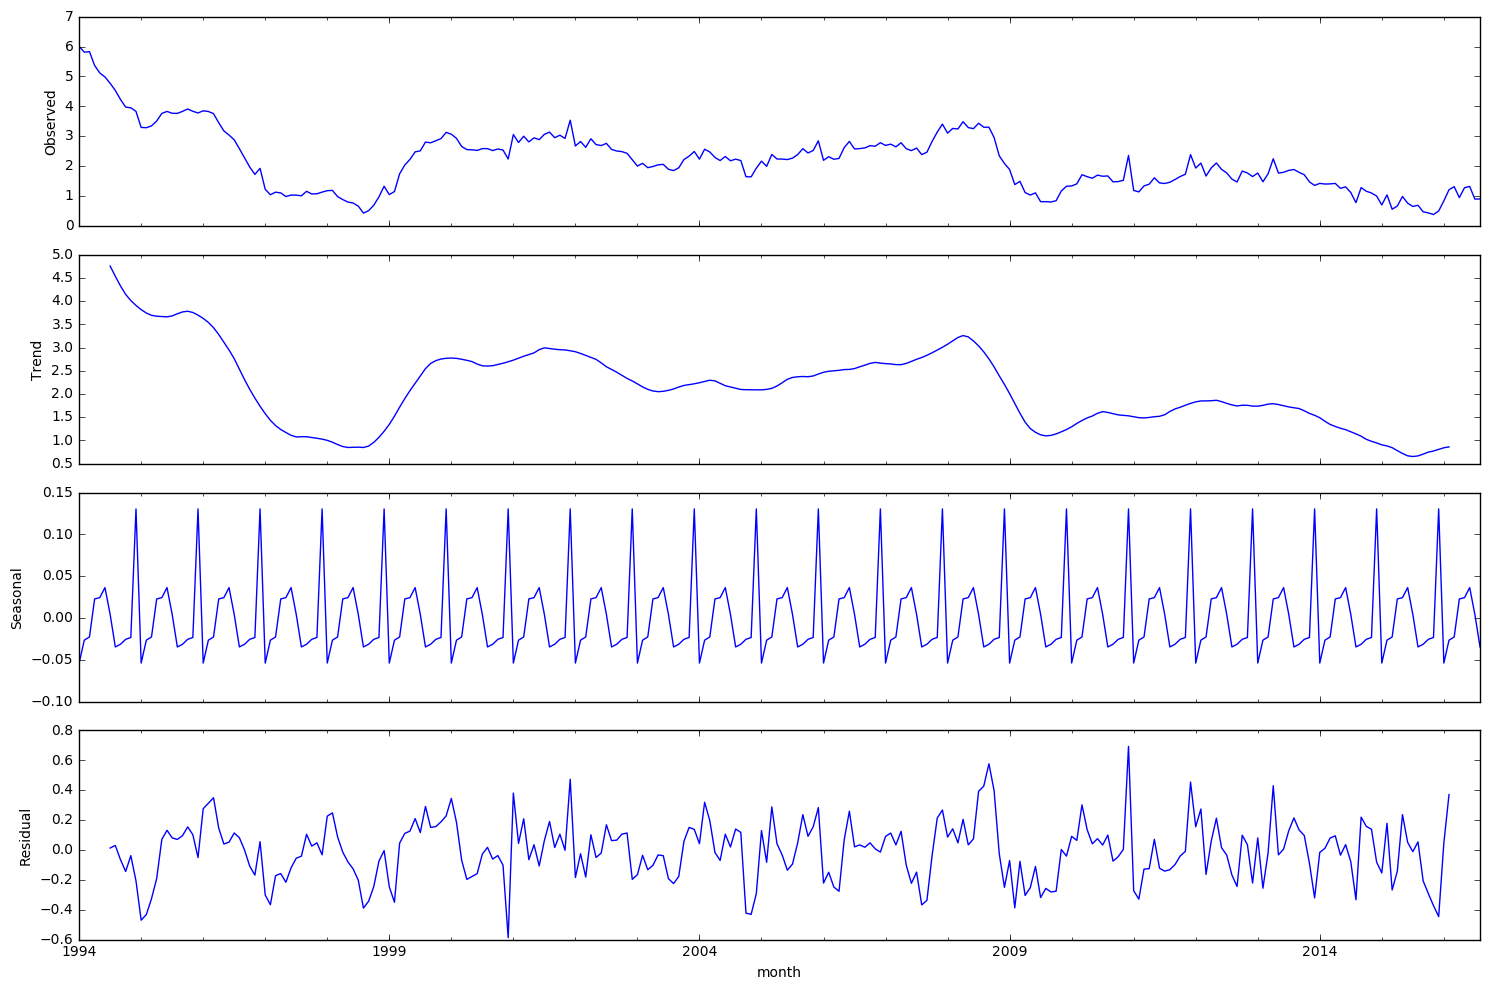

In [18]:
data['WAG_DF_diff'] = data.WAG_DF - data.WAG_DF.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_DF_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_DF_diff[12:])[1])

Критерий Дики-Фуллера отвергает нестационарность, но видно тренд еще немного присутствует, поэтому проведем еще и обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


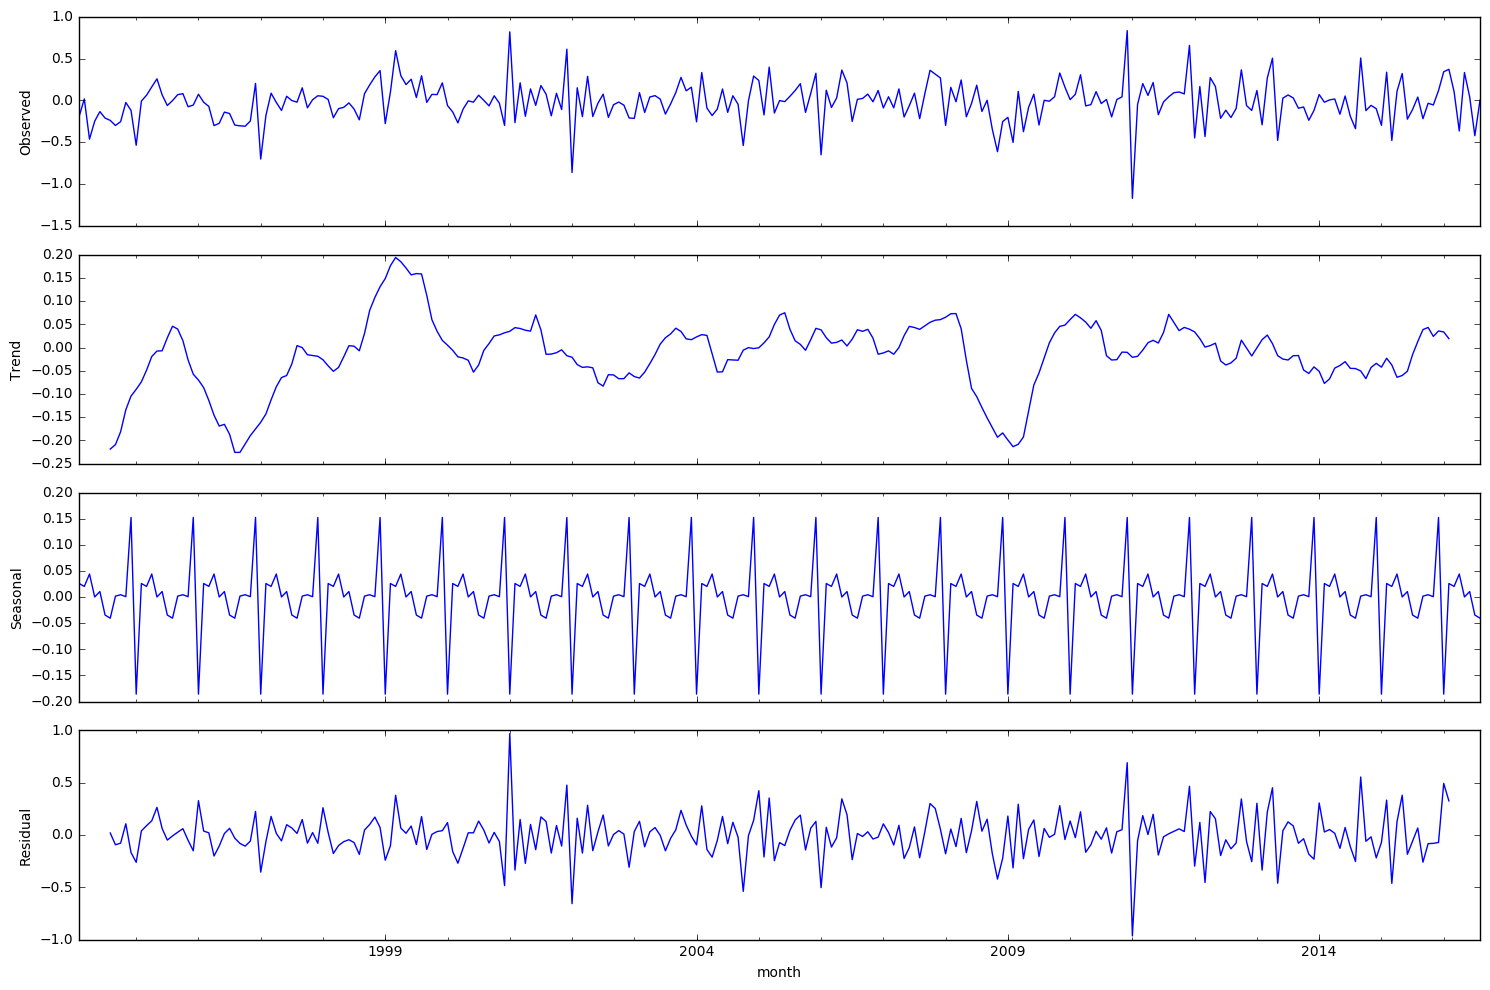

In [19]:
data['WAG_DF_diff2'] = data.WAG_DF_diff - data.WAG_DF_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_DF_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_DF_diff2[13:])[1])

Теперь тренд исчез, и остаток является шумом. Получили стационарный ряд

## Подберем начальное приближение для модели

Посмотрим на ACF и PACF полученного ряда:

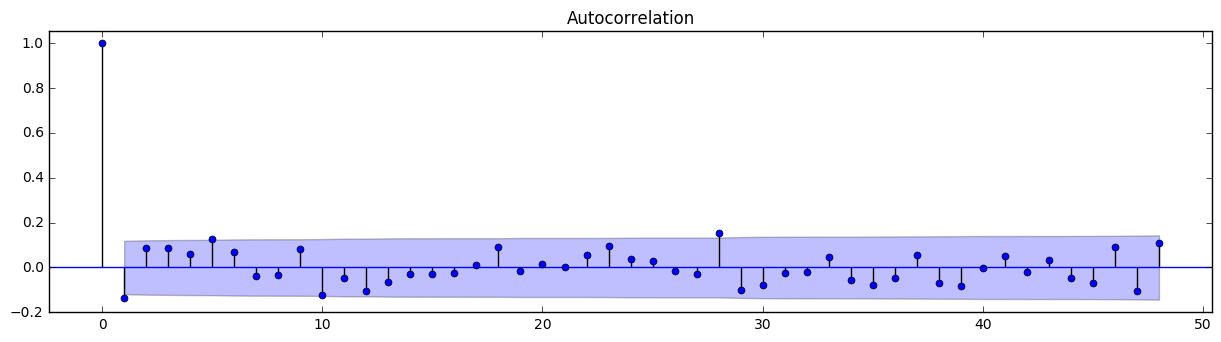

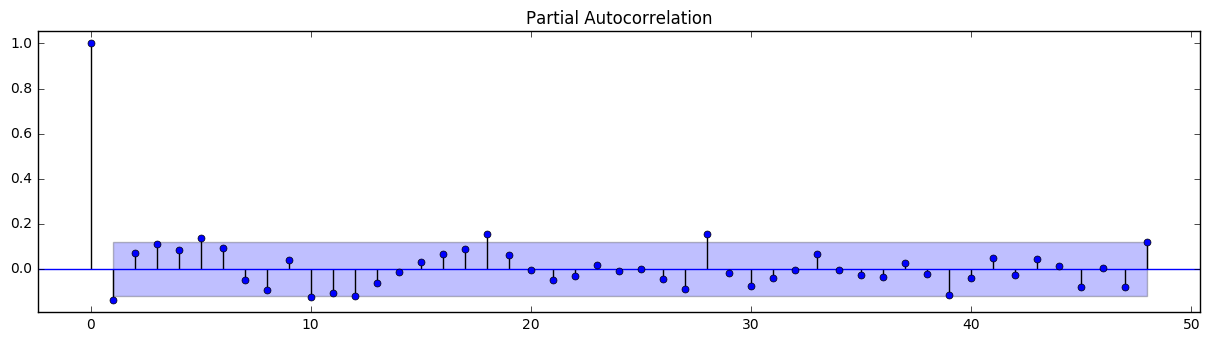

In [20]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_DF_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_DF_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=5

In [21]:
ps = range(0, 6)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [22]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [23]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_DF, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
Wall time: 26.6 s


In [24]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
41  (5, 1, 1, 0) -5.260132
42  (5, 1, 1, 1) -5.074467
25  (3, 1, 1, 0) -4.995859
37  (5, 0, 1, 0) -4.545934
40  (5, 1, 0, 1) -4.447610


Выбирем третью модель, в ней меньше значение параметров, но она не сильно хуже

In [28]:
model_best = sm.tsa.statespace.SARIMAX(data.WAG_DF, order=(3, d, 1), 
                                        seasonal_order=(1, D, 0, 12)).fit(disp=-1)

In [29]:
print(model_best.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             WAG_DF   No. Observations:                  284
Model:             SARIMAX(3, 1, 1)x(1, 1, 0, 12)   Log Likelihood                   8.498
Date:                            Fri, 30 Dec 2016   AIC                             -4.996
Time:                                    13:28:42   BIC                             16.898
Sample:                                01-01-1993   HQIC                             3.782
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4854      0.210      2.313      0.021       0.074       0.897
ar.L2          0.1630      0.075   

Её остатки:

Критерий Стьюдента: p=0.281916
Критерий Дики-Фуллера: p=0.000000


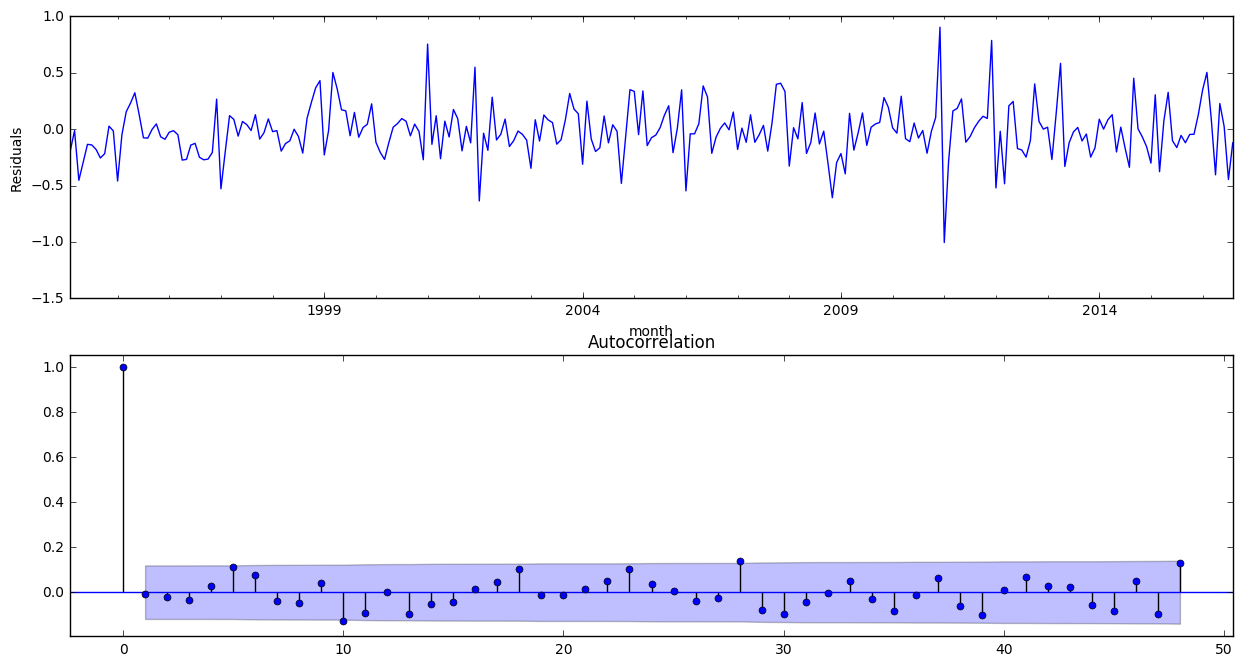

In [30]:
plt.figure(figsize(15,8))
plt.subplot(211)
model_best.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model_best.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(model_best.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(model_best.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

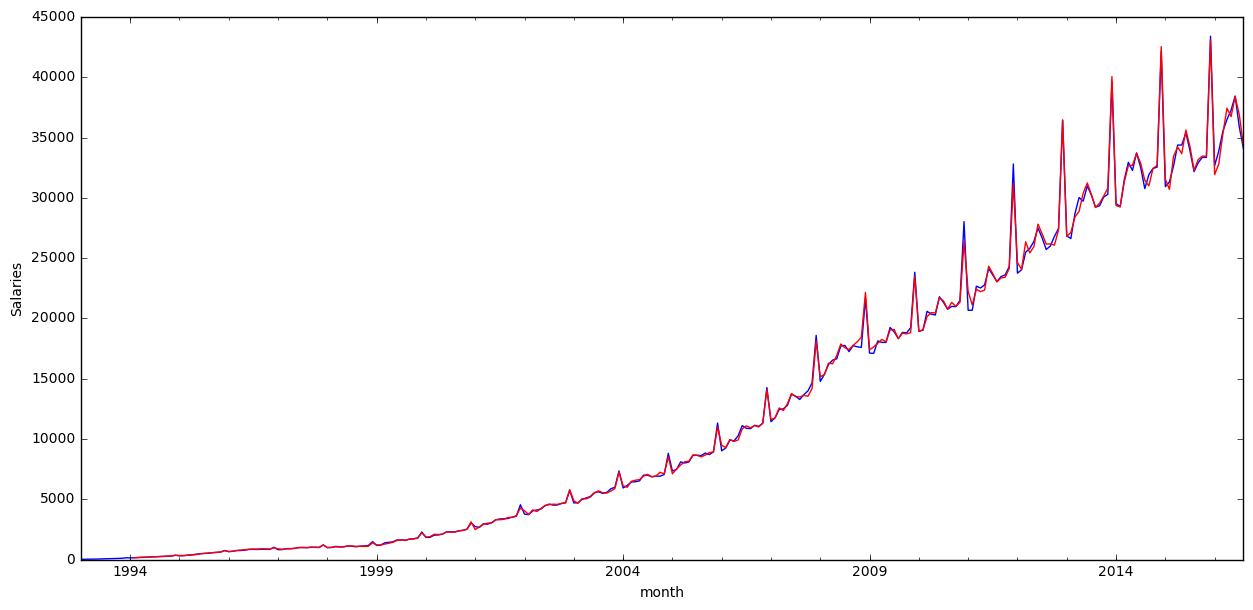

In [31]:
data['model'] = invboxcox(model_best.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salaries')
pylab.show()

## Прогноз

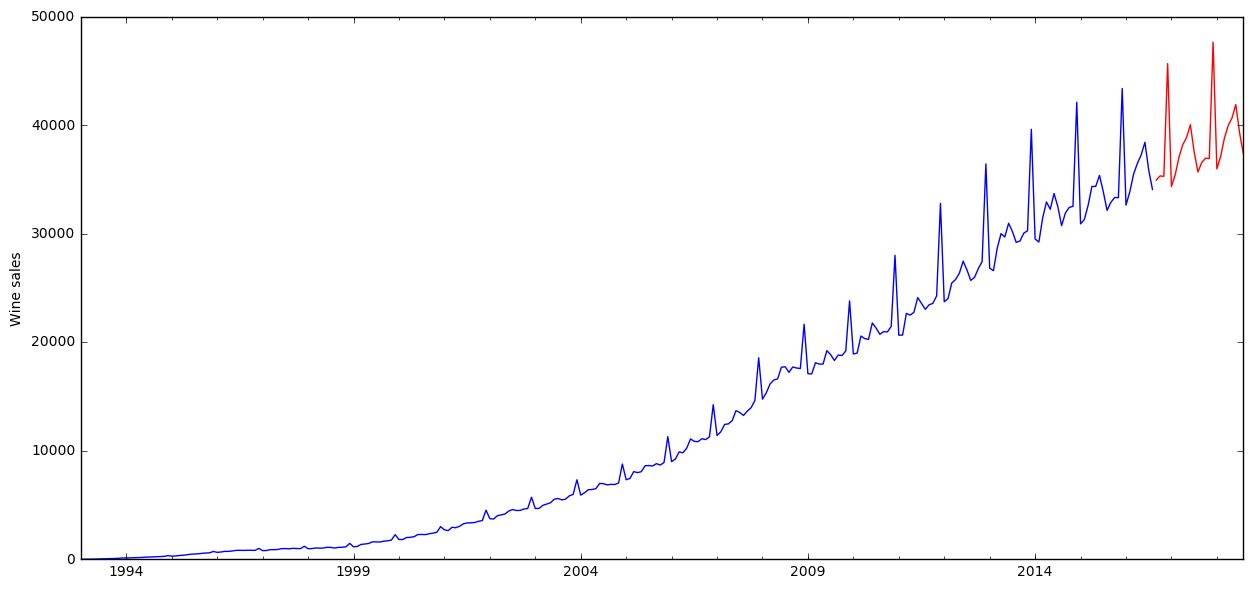

In [37]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(model_best.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()